This is the implementation of DCGAN with normalize input:
- Number of epochs: 100
- lr: 0.0002
- input: normalize (0.5, 0.5, 0.5)
- Add results dir for images and loss
- Add weight_decay: 1e-4

# Import

In [8]:
import argparse
import os
import time
import pickle

In [9]:
pip install torchnet

     |████████████████████████████████| 686kB 4.0MB/s 
     |████████████████████████████████| 204kB 14.7MB/s 
  Created wheel for torchnet: filename=torchnet-0.0.4-cp36-none-any.whl size=29747 sha256=e120c8b584e1f9a75c266a54a7f8e2bbed1a76c473e7d361f0f535b8b84178ed
  Stored in directory: /root/.cache/pip/wheels/e1/03/fb/1c212c2f20905cdf97fe39022946cf16b8e66ed754a6663400
  Created wheel for visdom: filename=visdom-0.1.8.9-cp36-none-any.whl size=655251 sha256=f4ccfdc442d6201b86acf7f2bb4de00d4e803db81d25d2c4211f1c3e335407e9
  Stored in directory: /root/.cache/pip/wheels/70/19/a7/6d589ed967f4dfefd33bc166d081257bd4ed0cb618dccfd62a
  Created wheel for torchfile: filename=torchfile-0.1.0-cp36-none-any.whl size=5711 sha256=fa8b406a3fcb4f1fa4bf07901c6b7367b1ed8c43ab140fc534cee98ab0b69355
  Stored in directory: /root/.cache/pip/wheels/b1/c3/d6/9a1cc8f3a99a0fc1124cae20153f36af59a6e683daca0a0814
Successfully built torchnet visdom torchfile


In [10]:
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchnet.meter import AverageValueMeter

# Define Arguments

In [11]:
parser = {
    'data_path': '../data/ut-zap50k/Shoes/Sneakers_and_athletic_shoes/',
    #ON MODIFIE LE NOMBRE D'EPOCHS
    'epochs': 100,
    'batch_size': 64,
    'lr': 0.0002,
    'image_size': 136,
    'scale_size': 64,
    'z_dim': 100,
    'G_features': 64,
    'D_features': 64,
    'image_channels': 3,
    'beta1': 0.5,
    'cuda': True,
    'seed': 7,
    'workers': 2,
    'results': './resultsDCGAN2_0523/'    
}
args = argparse.Namespace(**parser)
args.image_results = args.results + 'images/'
args.loss_results = args.results + 'loss/'
args.cuda = args.cuda and torch.cuda.is_available()

if not os.path.isdir(args.data_path):
    os.makedirs(args.data_path)
if not os.path.isdir(args.results):
    os.makedirs(args.results)
if not os.path.isdir(args.image_results):
    os.makedirs(args.image_results)
if not os.path.isdir(args.loss_results):
    os.makedirs(args.loss_results)
    
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

# Prepare Data

**Note: all iamges have size 136x102**

In [1]:
#activate my images folder in google drive 
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!ls '/content/drive/My Drive/Colab Notebooks/Sneakers_and_Athletic_Shoes_split'

1.zip


In [12]:
!unzip /data/ut-zap50k/Shoes/Sneakers_and_athletic_shoes/1.zip -d /data/ut-zap50k/Shoes/Sneakers_and_athletic_shoes

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: /data/ut-zap50k/Shoes/Sneakers_and_athletic_shoes/1/55.jpg  
  inflating: /data/ut-zap50k/Shoes/Sneakers_and_athletic_shoes/1/550.jpg  
  inflating: /data/ut-zap50k/Shoes/Sneakers_and_athletic_shoes/1/5500.jpg  
  inflating: /data/ut-zap50k/Shoes/Sneakers_and_athletic_shoes/1/5501.jpg  
  inflating: /data/ut-zap50k/Shoes/Sneakers_and_athletic_shoes/1/5502.jpg  
  inflating: /data/ut-zap50k/Shoes/Sneakers_and_athletic_shoes/1/5503.jpg  
  inflating: /data/ut-zap50k/Shoes/Sneakers_and_athletic_shoes/1/5504.jpg  
  inflating: /data/ut-zap50k/Shoes/Sneakers_and_athletic_shoes/1/5505.jpg  
  inflating: /data/ut-zap50k/Shoes/Sneakers_and_athletic_shoes/1/5506.jpg  
  inflating: /data/ut-zap50k/Shoes/Sneakers_and_athletic_shoes/1/5507.jpg  
  inflating: /data/ut-zap50k/Shoes/Sneakers_and_athletic_shoes/1/5508.jpg  
  inflating: /data/ut-zap50k/Shoes/Sneakers_and_athletic_shoes/1/5509.jpg  
  inflating: 

In [ ]:
from folder import ImageFolder

In [ ]:
from torchvision.datasets import ImageFolder

In [ ]:
from torchvision.transforms import ToPILImage
to_image = ToPILImage()

In [ ]:
def get_loader(image_root, batch_size, scale_size, num_workers=2, shuffle=True):
    #image_root = os.path.join(root, 'splits', split)
    dataset = ImageFolder(root=image_root, transform=transforms.Compose([
            transforms.Pad(34, fill=(255, 255, 255)), # padding images with (255,255,255) --> pad 255 in 3 channels
            transforms.CenterCrop((136,136)),
            transforms.Scale(scale_size),
            transforms.ToTensor(),
            
            #ATTENTION ici ca change on normalise 
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]))

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, num_workers=int(num_workers))
    #data_loader.shape = [int(num) for num in dataset[0][0].size()]

    return data_loader

In [ ]:
dataloader = get_loader(args.data_path, args.batch_size, args.scale_size)

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:257: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


## Test One Image

In [ ]:
test_image = 0
for data, _ in dataloader:
    print(data[0])
    test_image = data[0]
    break

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])


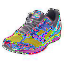

In [ ]:
to_image(test_image)

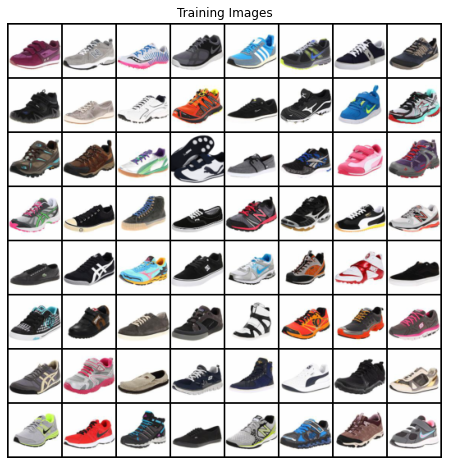

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")


# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# Define Model

## Define G

In [ ]:
class _netG(nn.Module):
    def __init__(self):
        super(_netG, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(args.z_dim, args.G_features * 8,
                               4, 1, 0, bias=False),
            nn.BatchNorm2d(args.G_features * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(args.G_features * 8, args.G_features * 4,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(args.G_features * 4),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(args.G_features * 4, args.G_features * 2,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(args.G_features * 2),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(args.G_features * 2, args.G_features,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(args.G_features),
            nn.ReLU(True),
            # state size. (ngf) x 16 x 16
            nn.ConvTranspose2d(args.G_features, args.image_channels,
                               4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 32 x 32
        )
        self._initialize_weights()
        
    # custom weight initialization
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                init.normal(m.weight, mean=0, std=0.02)
            elif isinstance(m, nn.BatchNorm2d):
                init.normal(m.weight, mean=1, std=0.02)
                init.constant(m.bias, 0)

    def forward(self, x):
        return self.main(x)

## Define D

In [ ]:
class _netD(nn.Module):
    def __init__(self):
        super(_netD, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(args.image_channels, args.D_features,
                      4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(args.D_features, args.D_features * 2,
                      4, 2, 1, bias=False),
            nn.BatchNorm2d(args.D_features * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(args.D_features * 2, args.D_features * 4,
                      4, 2, 1, bias=False),
            nn.BatchNorm2d(args.D_features * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(args.D_features * 4, args.D_features * 8,
                      4, 2, 1, bias=False),
            nn.BatchNorm2d(args.D_features * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(args.D_features * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        self._initialize_weights()
        
    # custom weight initialization
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                init.normal(m.weight, mean=0, std=0.02)
            elif isinstance(m, nn.BatchNorm2d):
                init.normal(m.weight, mean=1, std=0.02)
                init.constant(m.bias, 0)

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1)

## Save losses

In [ ]:
class Results():
    def __init__(self, results_path):
        self.D_losses = []
        self.G_losses = []
        self.D_reals = []
        self.D_fakes = []
        self.G_reals = []
        self.results_path = results_path
    
    def save_losses(self, D_loss, G_loss, D_real, D_fake, G_real):
        self.D_losses.append(D_loss)
        self.G_losses.append(G_loss)
        self.D_reals.append(D_real)
        self.D_fakes.append(D_fake)
        self.G_reals.append(G_real)
        
    def save_to_disk(self):
        f = open(self.results_path + "D_losses.pkl", "wb")
        pickle.dump(self.D_losses, f)
        f= open(self.results_path + "G_losses.pkl", "wb")
        pickle.dump(self.G_losses, f)
        f = open(self.results_path + "D_reals.pkl", "wb")
        pickle.dump(self.D_reals, f)
        f = open(self.results_path + "D_fakes.pkl", "wb")
        pickle.dump(self.D_fakes, f)
        f = open(self.results_path + "G_reals.pkl", "wb")
        pickle.dump(self.G_reals, f)
        

## Define Train and Generate

In [ ]:
def train(args, data_loader, netG, netD, G_optimizer, D_optimizer,
          criterion, epoch, result_losses):
    D_losses = AverageValueMeter()
    G_losses = AverageValueMeter()
    D_reals = AverageValueMeter()
    D_fakes = AverageValueMeter()
    G_reals = AverageValueMeter()
    
    start = time.time()
    # call Variable after .cuda()
    for i, (real, _) in enumerate(data_loader):
        batch_size = real.size(0)
        real_label = torch.ones(batch_size)
        fake_label = torch.zeros(batch_size)
        z = torch.randn(batch_size, args.z_dim, 1, 1)
        if args.cuda:
            real_label = real_label.cuda()
            fake_label = fake_label.cuda()
            real = real.cuda()
            z = z.cuda()
        real_label = Variable(real_label)
        fake_label = Variable(fake_label)
        real = Variable(real)
        z = Variable(z)
        
        real_output = netD(real)
        D_real_loss = criterion(real_output, real_label)
        D_real = real_output.data.mean()
        
        fake = netG(z)
        fake_output = netD(fake.detach())
        D_fake_loss = criterion(fake_output, fake_label)
        D_fake = fake_output.data.mean()
        
        D_loss = D_real_loss + D_fake_loss
        netD.zero_grad()
        D_loss.backward()
        D_optimizer.step()
        
        output = netD(fake)
        G_loss = criterion(output, real_label)
        G_real = output.data.mean()
        netG.zero_grad()
        G_loss.backward()
        G_optimizer.step()
        
        #.item() & .data.cpu().item()
        D_losses.add(D_loss.data.cpu().item() * batch_size, batch_size)
        G_losses.add(G_loss.data.cpu().item() * batch_size, batch_size)
        D_reals.add(D_real.data.cpu().item() * batch_size, batch_size)
        D_fakes.add(D_fake.data.cpu().item() * batch_size, batch_size)
        G_reals.add(G_real.data.cpu().item() * batch_size, batch_size)
        
    print("=> EPOCH {} | Time: {}s | D_loss: {:.4f} | G_loss: {:.4f}"
          " | D_real: {:.4f} | D_fake: {:.4f} | G_real: {:.4f}"
          .format(epoch, round(time.time()-start), D_losses.value()[0],
                  G_losses.value()[0], D_reals.value()[0],
                  D_fakes.value()[0], G_reals.value()[0]))
    result_losses.save_losses(D_losses.value()[0],
                  G_losses.value()[0], D_reals.value()[0],
                  D_fakes.value()[0], G_reals.value()[0])

In [ ]:
import torchvision.utils as vutils
#image liste pour l'animation
img_list = []


def generate(args, netG, epoch):
    z = torch.randn(args.batch_size, args.z_dim, 1, 1)
    if args.cuda:
        z = z.cuda()
    fake = netG(Variable(z, volatile=True))
    save_image(fake.data.cpu(), os.path.join(args.image_results,
        "fake_sample_epoch_{:02d}.png".format(epoch)), normalize=True)
      
    #image liste pour l'animation
    #add .data.cpu()
    img_list.append(vutils.make_grid(fake.data.cpu(), padding=2, normalize=True))

## Create Model, Define Loss and Optimizer

In [ ]:
netG = _netG()
netD = _netD()
criterion = nn.BCELoss()
if args.cuda:
    netD.cuda()
    netG.cuda()
    criterion.cuda()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


In [ ]:
D_optimizer = optim.Adam(netD.parameters(), lr=args.lr,
                         betas=(args.beta1, 0.999), weight_decay=1e-4)
G_optimizer = optim.Adam(netG.parameters(), lr=args.lr,
                         betas=(args.beta1, 0.999), weight_decay=1e-4)

## Run Train

In [ ]:
result_losses = Results(args.loss_results)
for epoch in range(0, args.epochs):
    train(args, dataloader, netG, netD, G_optimizer, D_optimizer,
          criterion, epoch, result_losses)
    generate(args, netG, epoch)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


=> EPOCH 0 | Time: 14s | D_loss: 0.6749 | G_loss: 8.2830 | D_real: 0.8523 | D_fake: 0.1611 | G_real: 0.0292


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([59])) that is different to the input size (torch.Size([59, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # Remove the CWD from sys.path while we load stuff.


=> EPOCH 1 | Time: 14s | D_loss: 0.6667 | G_loss: 4.2951 | D_real: 0.8007 | D_fake: 0.1995 | G_real: 0.0683
=> EPOCH 2 | Time: 14s | D_loss: 0.6263 | G_loss: 3.7053 | D_real: 0.7989 | D_fake: 0.2013 | G_real: 0.0832
=> EPOCH 3 | Time: 14s | D_loss: 0.7722 | G_loss: 3.3811 | D_real: 0.7620 | D_fake: 0.2372 | G_real: 0.1129
=> EPOCH 4 | Time: 14s | D_loss: 0.8319 | G_loss: 3.0713 | D_real: 0.7375 | D_fake: 0.2623 | G_real: 0.1299
=> EPOCH 5 | Time: 13s | D_loss: 0.8553 | G_loss: 2.8897 | D_real: 0.7259 | D_fake: 0.2723 | G_real: 0.1390
=> EPOCH 6 | Time: 13s | D_loss: 0.8768 | G_loss: 2.8443 | D_real: 0.7182 | D_fake: 0.2811 | G_real: 0.1422
=> EPOCH 7 | Time: 13s | D_loss: 0.8614 | G_loss: 2.7151 | D_real: 0.7137 | D_fake: 0.2827 | G_real: 0.1431
=> EPOCH 8 | Time: 13s | D_loss: 0.8636 | G_loss: 2.7148 | D_real: 0.7143 | D_fake: 0.2841 | G_real: 0.1467
=> EPOCH 9 | Time: 13s | D_loss: 0.8310 | G_loss: 2.6171 | D_real: 0.7206 | D_fake: 0.2787 | G_real: 0.1482
=> EPOCH 10 | Time: 13s | D_

## Save loss

In [ ]:
result_losses.save_to_disk()

## Get one REAL Image

In [ ]:
sample, _ = iter(dataloader).next()
save_image(sample, os.path.join(args.results, "real_sample.png"))

## Results

D and G’s losses changed during training


In [ ]:
loss_path = '/content/resultsDCGAN2_0523/loss/'
with open(loss_path+ 'D_losses.pkl', "rb") as f:
    D_losses = pickle.load(f)
    
with open(loss_path+ 'G_losses.pkl', "rb") as f:
    G_losses = pickle.load(f)

with open(loss_path+ 'D_reals.pkl', "rb") as f:
    D_reals = pickle.load(f)

with open(loss_path+ 'D_fakes.pkl', "rb") as f:
    D_fakes = pickle.load(f)

with open(loss_path+ 'G_reals.pkl', "rb") as f:
    G_reals = pickle.load(f)

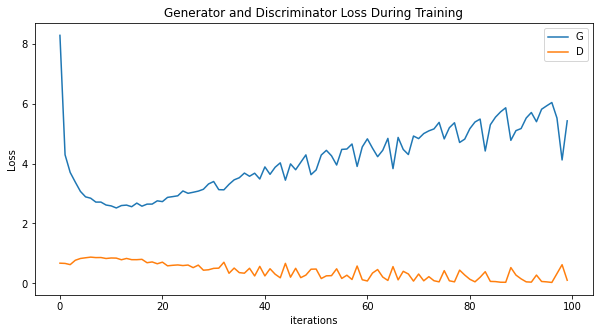

In [ ]:
#Loss versus training iteration

import matplotlib.pyplot as plt
import matplotlib.animation as animation

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig(loss_path + 'Loss_DCGAN2.png')
plt.show()

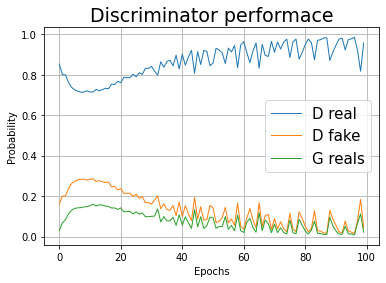

In [ ]:
plt.plot(D_reals, linewidth=1, label="D real")
plt.plot(D_fakes, linewidth=1, label="D fake")
plt.plot(G_reals, linewidth=1, label="G reals")
plt.grid()
plt.legend(fontsize=15)
plt.xlabel("Epochs", fontsize=10)
plt.ylabel("Probability", fontsize=10)
plt.title('Discriminator performace', fontsize=19)
plt.savefig(loss_path + 'D_DCGAN2.png')
plt.show()


##Visualization of G’s progression

In [ ]:
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128

In [ ]:
#%%capture
from IPython.display import HTML
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

##Real Images vs. Fake Images

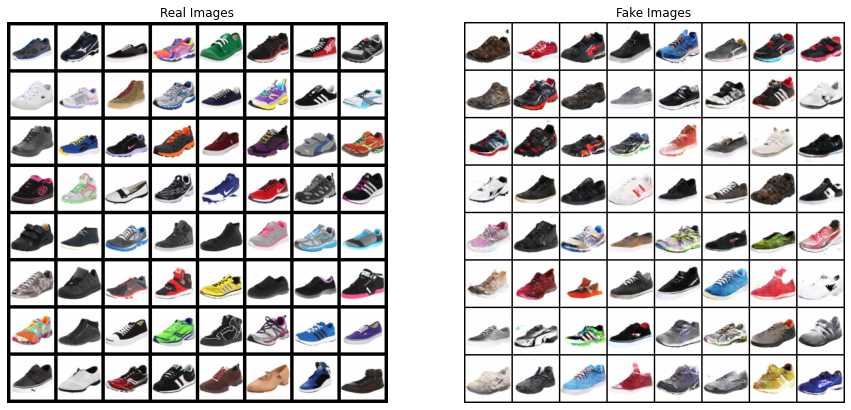

In [ ]:
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")


# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.savefig(loss_path + 'DUO_DCGAN2.png')
plt.show()

##Transfer learned weight in the model 
https://discuss.pytorch.org/t/how-to-transfer-learned-weight-in-the-same-model-without-last-layer/32824/6

In [ ]:
modelG = _netG()    
z = torch.randn(args.batch_size, args.z_dim, 1, 1)
outputG = modelG(z)    
print(outputG.shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


torch.Size([64, 3, 64, 64])


In [ ]:
modelD = _netD()    
z = torch.randn(args.batch_size, args.z_dim, 1, 1)                   
outputD = modelD(z)    
print(outputD.shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


RuntimeError: ignored

In [ ]:
# Save "trained" state_dict
torch.save(modelG.state_dict(), '/content/resultsDCGAN2_0523/weights/modelG.pth')
torch.save(modelD.state_dict(), '/content/resultsDCGAN2_0523/weights/modelD.pth')

In [ ]:

# Reload model G and load state_dict
#ici les poids sont transférés au model _netG()   
modelG.load_state_dict(torch.load('/content/resultsDCGAN2_0523/weights/modelG.pth'))
modelD.load_state_dict(torch.load('/content/resultsDCGAN2_0523/weights/modelD.pth'))

<All keys matched successfully>

In [ ]:
!zip -r "/content/resultsDCGAN2_0523.zip" "/content/resultsDCGAN2_0523"

  adding: content/resultsDCGAN2_0523/ (stored 0%)
  adding: content/resultsDCGAN2_0523/weights/ (stored 0%)
  adding: content/resultsDCGAN2_0523/weights/modelD.pth (deflated 8%)
  adding: content/resultsDCGAN2_0523/weights/modelG.pth (deflated 8%)
  adding: content/resultsDCGAN2_0523/loss/ (stored 0%)
  adding: content/resultsDCGAN2_0523/loss/G_reals.pkl (deflated 5%)
  adding: content/resultsDCGAN2_0523/loss/D_reals.pkl (deflated 9%)
  adding: content/resultsDCGAN2_0523/loss/D_DCGAN2.png (deflated 3%)
  adding: content/resultsDCGAN2_0523/loss/D_losses.pkl (deflated 5%)
  adding: content/resultsDCGAN2_0523/loss/G_losses.pkl (deflated 7%)
  adding: content/resultsDCGAN2_0523/loss/D_DCGAN4.png (deflated 3%)
  adding: content/resultsDCGAN2_0523/loss/D_fakes.pkl (deflated 5%)
  adding: content/resultsDCGAN2_0523/loss/Loss_DCGAN2.png (deflated 5%)
  adding: content/resultsDCGAN2_0523/loss/DUO_DCGAN2.png (deflated 2%)
  adding: content/resultsDCGAN2_0523/images/ (stored 0%)
  adding: content